# <a id='toc1_'></a>[TWO MOONS DATASET EXPERIMENTS](#toc0_)

The purpose of this notebook will be to analyze the behavior of the networks on a toy task, namely: the two moons dataset. This dataset is a simple binary classification task, where the goal is to separate two half-moon shaped clusters. The dataset is generated using the `make_moons` function from `sklearn.datasets`.

We want to see if the network manages to have uncertainty in the regions where the two moons are close to each other, and if it is able to correctly classify the points in the two moons.

**Table of contents**<a id='toc0_'></a>    
- [TWO MOONS DATASET EXPERIMENTS](#toc1_)    
  - [Imports](#toc1_1_)    
  - [Train / test split](#toc1_2_)    
  - [Configuration of the network](#toc1_3_)    
  - [Training the network](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports](#toc0_)
Importing libraries and setting the global variables

In [5]:

from utils import *
from dataloader import *
import models
import torch
import trainer
from optimizer import *
from sklearn.datasets import make_moons
import palettable
from torch.utils.data import DataLoader, TensorDataset

SEED = 0  # Random seed
N_NETWORKS = 1  # Number of networks to train
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### PATHS ###
SAVE_FOLDER = "saved-two-moons"
DATASETS_PATH = "datasets"

### SEED ###
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.set_default_device(DEVICE)
    torch.set_default_dtype(torch.float32)
np.random.seed(SEED)
torch.manual_seed(SEED)
    

## <a id='toc1_2_'></a>[Train / test split](#toc0_)

We split the dataset into a train and test set. The test set will be used to evaluate the performance of the network, while the train set will be used to train the network. We separate the data into:
- `x_train`: the input data for the training set with 1024 points
- `y_train`: the labels for the training set with 1024 points
- `x_test`: the input data for the test set with 256 points
- `y_test`: the labels for the test set with 256 points

In [6]:
tr_size = 200
te_size = 50

### CREATE TWO MOONS DATASET ###
X, y = make_moons(n_samples=tr_size, noise=0.1, random_state=SEED)
Xt, yt = make_moons(n_samples=te_size, noise=0.1, random_state=SEED+1)

# normalize dataset
X = (X - X.mean(axis=0)) / X.std(axis=0)

X_train = X
y_train = y
X_test = Xt
y_test = yt

INPUT_SIZE = X_train.shape[1]

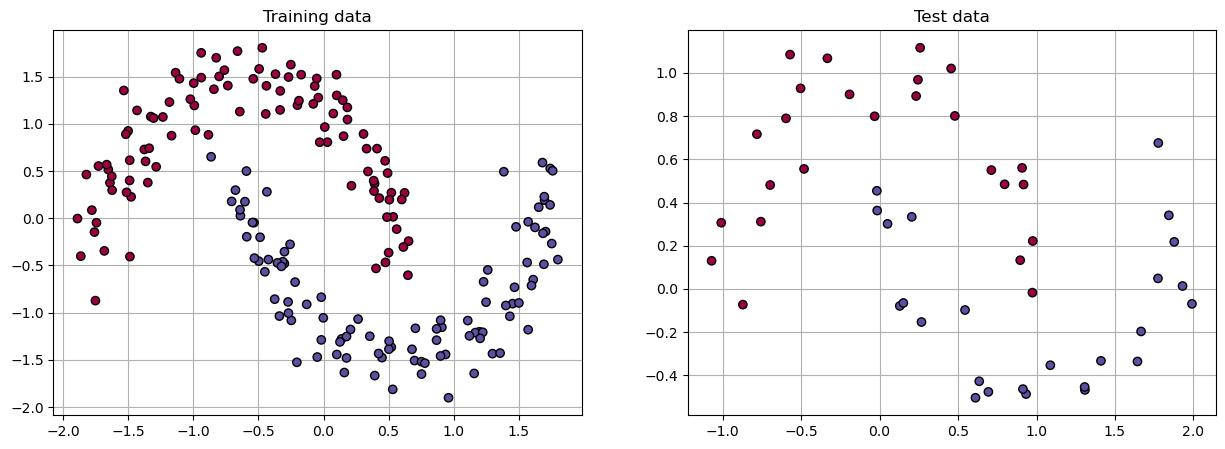

In [7]:
### PLOT X, y ###
# subplot for training data and test data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].grid(True)
ax[1].grid(True)
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)
ax[0].set_title("Training data")
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)
ax[1].set_title("Test data")
plt.show()

## <a id='toc1_3_'></a>[Configuration of the network](#toc0_)

We configure the network by setting the parameters within a dictionary.

In [8]:

### NETWORK CONFIGURATION ###
networks_data = [
    {
        "nn_type": models.DNN,
        "nn_parameters": {
            "layers": [INPUT_SIZE, 64, 64, 2],
            "device": DEVICE,
            "dropout": False,
            "batchnorm": False,
            "bias": True,
            "latent_weights": False,
        },
        "training_parameters": {
            'n_epochs': 1000,
            'batch_size': tr_size,
            'test_mcmc_samples': 10,
        },
        "criterion": torch.functional.F.nll_loss,
        "reduction": "mean",
        "optimizer": BayesBiNN,
        "optimizer_parameters": {
            "temperature": 1,
            "num_mcmc_samples": 10,
            "init_lambda": 15,
            "lr": 0.0001,
            "beta": 0.99
        },
    }
]

train_tensor = GPUTensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
test_tensor = GPUTensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = GPUDataLoader(train_tensor, batch_size=networks_data[0]["training_parameters"]["batch_size"], shuffle=True)
test_loader = GPUDataLoader(test_tensor, batch_size=te_size, shuffle=False)

for index, data in enumerate(networks_data):

    ### ACCURACY INITIALIZATION ###
    accuracies = []
    batch_size = data['training_parameters']['batch_size']
    ### FOR EACH NETWORK IN THE DICT ###
    for iteration in range(N_NETWORKS):
        ### SEED ###
        np.random.seed(SEED + iteration)
        torch.manual_seed(SEED + iteration)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(SEED + iteration)
        ### NETWORK INITIALIZATION ###
        model = data['nn_type'](**data['nn_parameters'])
        ### INSTANTIATE THE TRAINER ###
        network = trainer.BayesTrainer(batch_size=batch_size,
                                        model=model, **data, device=DEVICE)
        ### TRAINING ###
        network.fit(
            train_loader, **data['training_parameters'], test_loader=[test_loader], verbose=True)

Epoch 1000/1000: 100%|██████████| 1000/1000 [00:08<00:00, 112.82it/s, current_loss=0.767, task 1=72.00%]


## <a id='toc1_4_'></a>[Training the network](#toc0_)

## Exploiting the results

In [9]:
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors

    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap

    cmap = LinearSegmentedColormap.from_list(name=name,
                                             colors=[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap
custom_map = custom_div_cmap(
    11, mincol='#86C29C', midcol='0.9', maxcol='#F5D752')

/tmp/ipykernel_129865/1044059748.py:33: UserWarning: Use the colorbar set_ticks() method instead.
  cbar.ax.set_yticks(np.arange(0, 1.1, 1 / (clevels+1)))


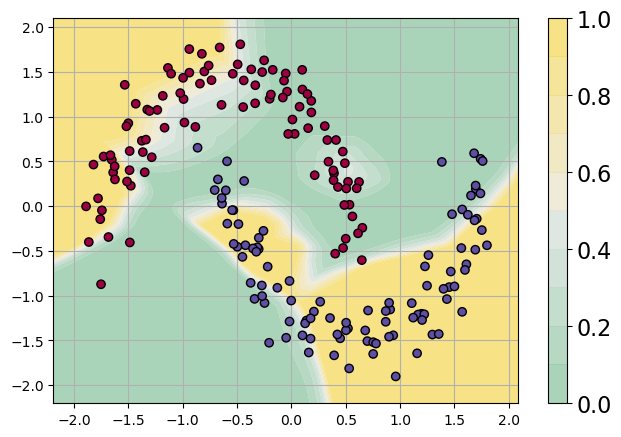

In [10]:
torch.manual_seed(SEED)
### CREATE A MESHGRID ###
# create a meshgrid for the whole dataset such that we can plot the predictions for each point
h = .01  # step size in the mesh
buffer = 0.3 # buffer for the axes
x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer # min and max of the first feature
y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer # min and max of the second feature
xx,yy= np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
grid = torch.from_numpy((grid - X.mean(axis=0)) / X.std(axis=0)).float().to(DEVICE)
custom_map = custom_div_cmap(
    11, mincol='#86C29C', midcol='0.9', maxcol='#F5D752')

### PREDICT ###
N_TEST_SAMPLES = 10
clevels = 9
Z = network.predict(grid, N_TEST_SAMPLES) 
Z = torch.stack(Z, dim=0)
Z = Z.mean(dim=0)
# remove the log from the softmax
Z = torch.exp(Z)
# only keep the values for the class with the highest probability
Z = torch.max(Z, dim=1)[0].reshape(xx.shape).cpu()
# plot the predictions with the uncertainty
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.grid(True)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)

# plot the uncertainty with contourf based on mean and std
c = ax.contourf(xx, yy, Z, alpha=0.7, levels=clevels, antialiased=True, cmap=custom_map, zorder=1)

cbar = plt.colorbar(c, ax=ax)
cbar.ax.set_yticks(np.arange(0, 1.1, 1 / (clevels+1)))
cbar.ax.tick_params(axis='both', which='major', labelsize=16)

plt.show()
